In [1]:
import random
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

max_words = 2000
max_len = 40
num_classes = 2

# Training
epochs = 40
batch_size = 512
print_batch_n = 100
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
df = pd.read_excel("отзывы за лето.xls")

In [3]:
df.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [4]:
# Убираем тройки
df = df[df['Rating'] != 3]

# Разметим классы
replace = {1: 0,
           2: 0,
           4: 1,
           5: 1}
df['Rating'] = df['Rating'].replace(replace)

In [5]:
df

,Rating,Content,Date
0,1,It just works!,2017-08-14
1,1,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,1,Отлично все,2017-08-14
3,1,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,1,"Очень удобно, работает быстро.",2017-08-14
...,...,...,...
20654,0,"Ну и шляпа,с роот правами бесполезная прога,ра...",2017-06-01
20655,1,Ок,2017-06-01
20656,1,Доволен,2017-06-01
20657,0,"Песопаснасть, рут ни нужын",2017-06-01


In [6]:
# Разобьем датасет
from sklearn.model_selection import train_test_split
df_train, df_test= train_test_split(df.drop(columns='Date'), test_size=0.25, random_state=42)

### Предобработка

In [7]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [8]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['Content'] = df_train['Content'].apply(preprocess_text)
df_test['Content'] = df_test['Content'].apply(preprocess_text)

In [9]:
train_corpus = " ".join(df_train["Content"])
train_corpus = train_corpus.lower()

In [10]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\den41\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Отфильтруем данные

и соберём в корпус N наиболее частых токенов

In [11]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [12]:
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [13]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [14]:

def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [15]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["Content"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["Content"]], dtype=np.int32)

In [16]:
x_train.shape

(14811, 40)

In [17]:
class Net(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim=128, out_channel=128, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)  # Переворачиваем чтоб ходить по высоте а не длинне, а permute верно перевернет в отличие от vie
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        return output

In [18]:
from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
        y = F.one_hot(y, num_classes=2)
        return x, y
    
    def __len__(self):
        return len(self.data)

In [19]:
model = Net(vocab_size=max_words).to(device)

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-5)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()  # Этот лосс мне более знаком

    
train_dataset = DataWrapper(x_train, df_train['Rating'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = DataWrapper(x_test, df_test['Rating'].values)
test_loader = DataLoader(test_dataset, batch_size=len(x_test), shuffle=True)

loss_history = []
test_lost_history = []

for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()        
        
        # compute output
        output = model(data.to(device))        
        
        # compute gradient and do SGD step
        loss = criterion(output, target.to(device).float())
        loss.backward()
        
        optimizer.step()
        
        if i%print_batch_n == 0:
            loss = loss.float().item()
            print(f"Step {i}: loss={loss}")
            loss_history.append(loss)
            
    data, target = next(iter(test_loader))
    # compute output
    output = model(data.to(device))        

    # compute gradient and do SGD step
    test_loss = criterion(output, target.to(device).float())
    test_lost_history.append(test_loss.float().item())
    print(f"Test loss={loss}\n")

Net(
  (embedding): Embedding(2000, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
Parameters: 305538
Train epoch 1/40
Step 0: loss=1.1974667310714722
Test loss=0.3270736634731293

Train epoch 2/40
Step 0: loss=0.3534228205680847
Test loss=0.3452039659023285

Train epoch 3/40
Step 0: loss=0.30612868070602417
Test loss=0.3199276924133301

Train epoch 4/40
Step 0: loss=0.32517746090888977
Test loss=0.29052284359931946

Train epoch 5/40
Step 0: loss=0.28668147325515747
Test loss=0.3220072090625763

Train epoch 6/40
Step 0: loss=0.2529218792915344
Test loss=0.2281748503446579

Train epoch 7/40
Step 0: loss=0.24395392835140228
Test loss=0.2670406699180603

Train epoch 8/40
Step 0: loss=0.2641643285751343
Test loss=0.2579937279224396

Train epoch 9/40
Step 0: loss=0.31976497173309326
Test loss=0.2363385558128357

Train epoch 10/40
Step 0: loss=0.2569216787815094
Test loss=0.2551689147949219

Tra

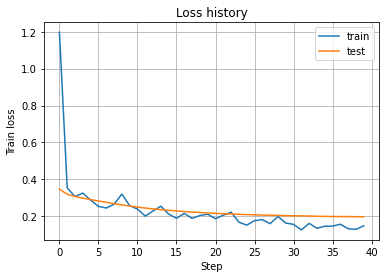

In [20]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history, label='train')
plt.plot(test_lost_history, label='test')
plt.legend()
plt.show()